# Lab 1 Linear Regression- Group 12
## Pragya Naruka: 002737744
## Shaswat Sinha: 002776180


In [ ]:
# importing the libraries
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [34]:
class linearregression:
    # declaring all the atrributes in the init function
    def __init__(self, X,y, tolerance, learning_rate,gd,reg, sgd,lamda=0.01,
                 maxIteration=6000,batch_size = 1):
        self.X = X
        self.y = y
        self.tolerance = tolerance
        self.lamda = lamda
        self.maxIteration = maxIteration
        self.reg = reg
        self.gd= gd
        self.learning_rate = learning_rate
        self.sgd = sgd
        self.batch_size = batch_size

    # Splitting the data sets
    def splitData(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size = 0.25, random_state=0)
        return X_train, X_test, y_train, y_test

    # Add column of ones to the dataframe for regularization
    def add_X0(self,X):
        return np.column_stack([np.ones([X.shape[0],1]),X])

    #  line chart creation of the cost vs iteration
    def plotCost(self):
        plt.plot(self.error_sequence)
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.title("Iterations vs cost")
        plt.show()

    # Normalizing the training dataset and also adding the regularization
    def normalizetraindata(self, X):
        self.mean= X.mean(0)
        self.std = np.std(X)
        X = (X - self.mean)/self.std
        X = self.add_X0(X)
        return X, self.mean, self.std

    # Normalizing the testing dataset and also adding the regularization
    def normalizetestdata(self, X_test,mean, std):
        X_test = (X_test - mean)/std
        X_test = self.add_X0(X_test)
        return X_test

    # rank of the matrix
    def rank(self, X, eps= 0):
        u,s,vh = np.linalg.svd(X)
        return len([x for x in s if abs(x)>eps])

    # Checking whether the matrix is full rank or not
    def checkfullrank(self, X):
        x_rank = self.rank(X)
        if x_rank == min(X.shape[0],X.shape[1]):
            self.full_rank = True
            print("Data is full rank")
        else:
            print("Data is not full rank")
            self.full_rank = False
        return self.full_rank

    #find the invertibility of the matrix
    def checklowrank(self, X):
        if X.shape[0] < X.shape[1]:
            print('It is low_rank')
            self.low_rank = True
            # matrix  not invertible
        else:
            self.low_rank = False
            # matrix invertible
        return self.low_rank

    # Closed form solution function which applies the normal equation formula depending
    # if the matrix is regularized or not
    def closedformsolution(self, X,y, reg):
        if reg == False:
            return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) # weight
        else:
            return np.linalg.inv(X.T.dot(X)-(self.lamda)*np.eye(X.shape[1])).dot(X.T).dot(y) # weights with regularisation

    # Predict function
    def predict(self, X):
        return X.dot(self.w)

    # SSE function
    def sse(self,X,y):
        y_hat = self.predict(X)
        return ((y_hat-y)**2).sum()

    # RMSE function
    def rmse(self,X,y):
        y_hat = self.predict(X)
        return np.sqrt((((y_hat-y)**2)/X.shape[0]).sum())

    # Cost derivative based on the presence of regularization or not
    def costderivation(self, X,y):
        pred = self.predict(X)
        if self.reg == False:
            return (pred- y).dot(X)
        else:
            return (pred-y).dot(X) + (self.lamda * self.w)

    # Cost function for RMSE
    def costfunction(self,X,y):
        return self.rmse(X,y)/2

#This function computes the gradient descent or stochastic gradient descent based on the provided parameters.
#Stochastic gradient descent is computed using a specified batch size.
#The plot function generates and displays a plot
    def gradientdescent(self, X,y):
        self.error_sequence =[]
        last = np.inf
        for tq in tqdm(range(self.maxIteration)):
            if self.gd == True: #gradient descent
                self.w = self.w - (self.learning_rate * self.costderivation(X,y))
            elif self.sgd == True: #stochastic gradient descent
                for i in range(0, X.shape[0], self.batch_size):
                    X_batch = X[i:i+self.batch_size, : ]
                    y_batch = y[i:i+self.batch_size]
                    self.w = self.w - (self.learning_rate * self.costderivation(X_batch,y_batch))
            curr = self.rmse(X,y)
            diff = last - curr
            last = curr
            self.error_sequence.append(curr)
            if np.abs(diff) < self.tolerance:
                print("Model stopped Learning")
                break
        self.plotCost()
        return self.w

# The purpose of the fit function is to adjust the data to the model based on the given parameters.
# Essential conditions are examined for both the closed-form solution and the gradient descent/stochastic gradient descent algorithms.
    def fit(self):
        self.type_of_model =""
        X_train, X_test, y_train, y_test = self.splitData()
        X_train , self.train_mean, self.train_std = self.normalizetraindata(X_train)
        X_test = self.normalizetestdata(X_test,self.train_mean, self.train_std)

        if self.checkfullrank(X_train) == True and self.checklowrank(X_train)== False and self.gd== False and self.sgd== False:
            self.type_of_model = "Solving using closed form solution "+ "".join(["Regularized" if self.reg==True else "Non Regularised"])

            print()
            print(self.type_of_model)

            self.w = self.closedformsolution(X_train,y_train,self.reg)
            rmse_test = self.rmse(X_test,y_test)
            sse_test = self.sse(X_test, y_test)
            print("Root Mean Square Error: ",rmse_test)
            print("Sum of Square Error: ", sse_test)

        else:
            self.type_of_model = "" + "".join(["Solving using Gradient Descent "if self.gd== True else "Solving Using Stochastic Gradient Descent"]) + " ".join([" Regularised" if self.reg==True else " Not-Regularised"])

            print()
            print(self.type_of_model)
            self.w = np.ones(X_train.shape[1],dtype = np.float64)*0
            self.w= self.gradientdescent(X_train,y_train)
            rmse_test = self.rmse(X_test,y_test)
            sse_test = self.sse(X_test, y_test)
            print("Root Mean Square Error: ",rmse_test)
            print("Sum of Square Error: ", sse_test)

# Housing Dataset

In [32]:
#import housing data
df = pd.read_csv("housing.csv")
df

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
501,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
502,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
503,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [8]:
X = df.values[:, 0:-1]
y = df.values[:,-1]

In [40]:
# creating an instance of linearregression model where gd, reg and sgd is false, i.e using closed form solution
model = linearregression(X, y,gd=False,reg=False,sgd = False,tolerance = 0.0005,learning_rate = 0.1)
model.fit()

Data is full rank

Solving using closed form solution Non Regularised
Root Mean Square Error:  11.220113263451855
Sum of Square Error:  32479.862944329565


In [41]:
model = linearregression(X, y,gd=False,reg=True,sgd = False,tolerance = 0.0005,learning_rate = 0.1)
model.fit()

Data is full rank

Solving using closed form solution Regularized
Root Mean Square Error:  11.233649537912566
Sum of Square Error:  32558.279540685944


Data is full rank

Solving using Gradient Descent  Not-Regularised


  6%|▌         | 330/6000 [00:00<00:00, 15801.00it/s]

Model stopped Learning


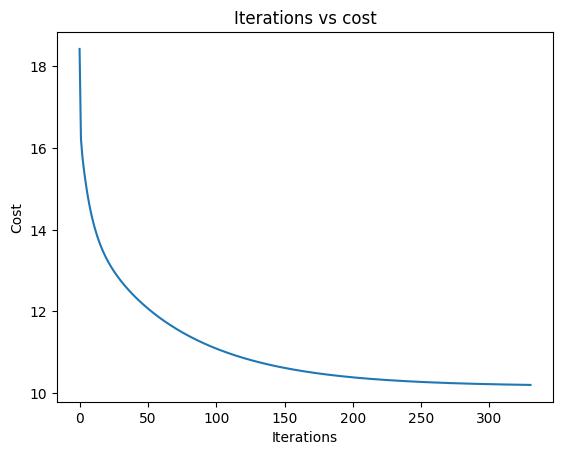

Root Mean Square Error:  11.25022989275165
Sum of Square Error:  32654.459541058797


In [43]:
model = linearregression(X, y,gd=True,reg=False,sgd = False,tolerance = 0.0005,learning_rate = 0.001)
model.fit()

Data is full rank

Solving using Gradient Descent  Regularised


  6%|▌         | 330/6000 [00:00<00:00, 14479.31it/s]

Model stopped Learning


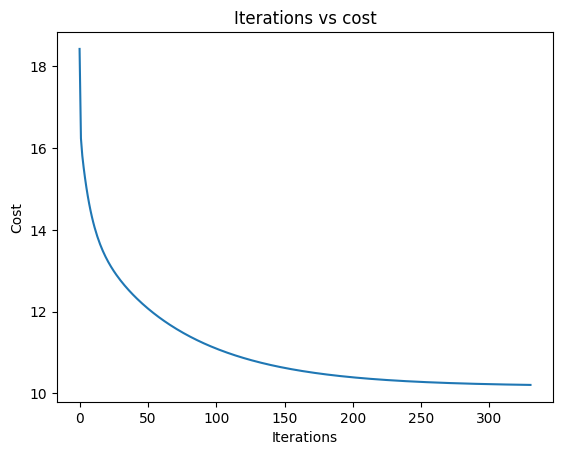

Root Mean Square Error:  11.2499204574
Sum of Square Error:  32652.663256839383


In [44]:
model = linearregression(X, y,gd=True,reg=True,sgd = False,tolerance = 0.0005,learning_rate = 0.001)
model.fit()

Data is full rank

Solving Using Stochastic Gradient Descent Not-Regularised


  0%|          | 28/6000 [00:00<00:26, 226.46it/s]

Model stopped Learning


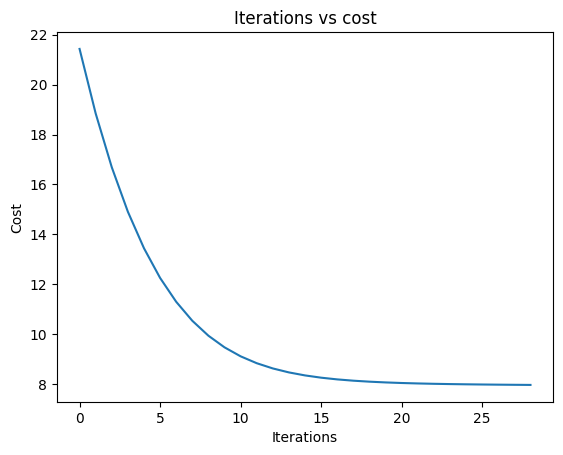

Root Mean Square Error:  7.744012408610301
Sum of Square Error:  7616.155479458211


In [13]:
model = linearregression(X, y,gd=False,reg=False,sgd = True,tolerance = 0.005,
                          learning_rate = 0.0004,batch_size = 1)
model.fit()

Data is full rank

Solving Using Stochastic Gradient Descent Regularised


  0%|          | 30/6000 [00:00<00:28, 212.68it/s]

Model stopped Learning


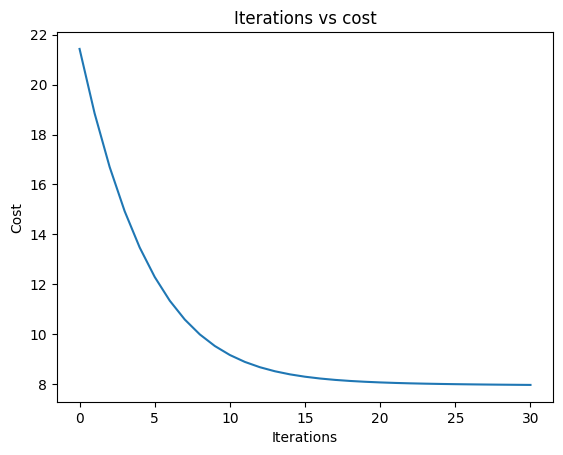

Root Mean Square Error:  7.739266167740866
Sum of Square Error:  7606.822583522576


In [15]:
model = linearregression(X, y,gd=False,reg=True,sgd = True,tolerance = 0.005,
                          learning_rate = 0.0004,batch_size = 1)
model.fit()

# Yacht Dataset

In [16]:
df1 = pd.read_csv("yachtData.csv")
df1

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
...,...,...,...,...,...,...,...
302,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
303,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
304,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
305,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


In [17]:
X = df1.values[:, 0:-1]
y = df1.values[:,-1]

In [63]:
model = linearregression(X, y,gd=False,reg=False,sgd = False,tolerance = 0.005,
                          learning_rate = 0.001)
model.fit()

Data is full rank

Solving using closed form solution Non Regularised
Root Mean Square Error:  11.220113263451855
Sum of Square Error:  32479.862944329565


In [62]:
model = linearregression(X, y,gd=False,reg=True,sgd = False,tolerance = 0.005,
                          learning_rate = 0.001)
model.fit()

Data is full rank

Solving using closed form solution Regularized
Root Mean Square Error:  11.233649537912566
Sum of Square Error:  32558.279540685944


Data is full rank

Solving using Gradient Descent  Not-Regularised


  4%|▍         | 268/6000 [00:00<00:00, 15731.43it/s]

Model stopped Learning


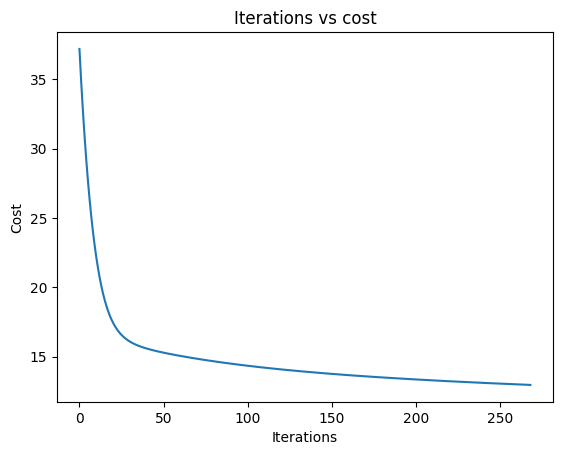

Root Mean Square Error:  13.048628789592968
Sum of Square Error:  43928.81202845735


In [61]:
model = linearregression(X, y,gd=True,reg=False,sgd = False,tolerance = 0.005,
                          learning_rate = 0.0001)
model.fit()

Data is full rank

Solving using Gradient Descent  Regularised


  6%|▌         | 364/6000 [00:00<00:00, 18678.30it/s]

Model stopped Learning


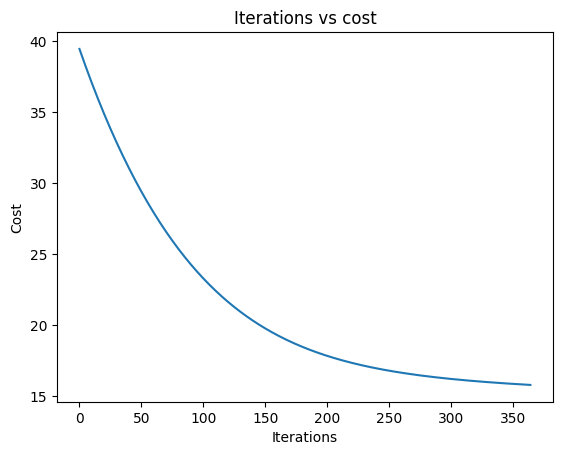

Root Mean Square Error:  14.913401421822401
Sum of Square Error:  57381.66182785091


In [64]:
model = linearregression(X, y,gd=True,reg=True,sgd = False,tolerance = 0.005,
                          learning_rate = 0.00001)
model.fit()

Data is full rank

Solving Using Stochastic Gradient Descent Not-Regularised


100%|██████████| 6000/6000 [00:36<00:00, 165.24it/s]


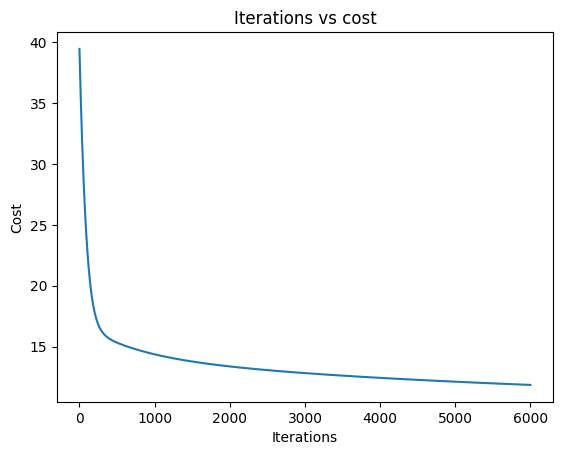

Root Mean Square Error:  12.367044918534951
Sum of Square Error:  39459.50040440178


In [59]:
model = linearregression(X, y,gd=False,reg=False,sgd = True,tolerance = 0.0001,learning_rate = 0.00001,batch_size = 1)
model.fit()

Data is full rank

Solving Using Stochastic Gradient Descent Regularised


  4%|▍         | 225/6000 [00:01<00:36, 156.15it/s]


Model stopped Learning


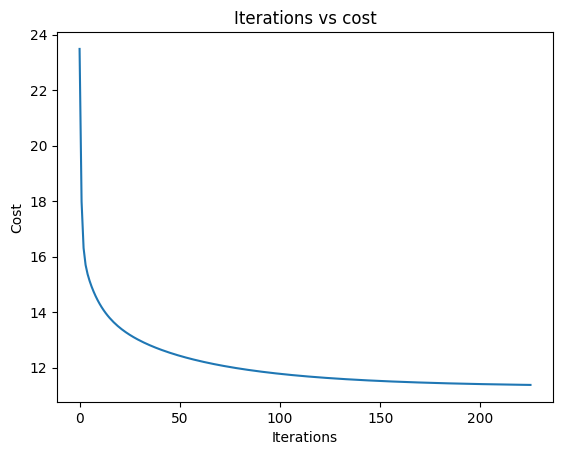

Root Mean Square Error:  11.801575370666589
Sum of Square Error:  35933.51275721724


In [58]:
model = linearregression(X, y,gd=False,reg=True,sgd = True,tolerance = 0.001,
                          learning_rate = 0.001,batch_size = 1)
model.fit()

# Concrete Dataset

In [24]:
df2 = pd.read_csv("concreteData.csv")
df2

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
...,...,...,...,...,...,...,...,...,...
1024,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1025,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1026,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1027,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [25]:
X = df2.values[:, 0:-1]
y = df2.values[:,-1]

In [57]:
model = linearregression(X, y,gd=False,reg=False,sgd = False,tolerance = 0.0001,learning_rate = 0.0005)
model.fit()

Data is full rank

Solving using closed form solution Non Regularised
Root Mean Square Error:  11.220113263451855
Sum of Square Error:  32479.862944329565


In [56]:
model = linearregression(X, y,gd=False,reg=True,sgd = False,tolerance = 0.0001, learning_rate = 0.0005)
model.fit()

Data is full rank

Solving using closed form solution Regularized
Root Mean Square Error:  11.233649537912566
Sum of Square Error:  32558.279540685944


Data is full rank

Solving using Gradient Descent  Not-Regularised


 33%|███▎      | 1964/6000 [00:00<00:00, 19721.60it/s]

Model stopped Learning


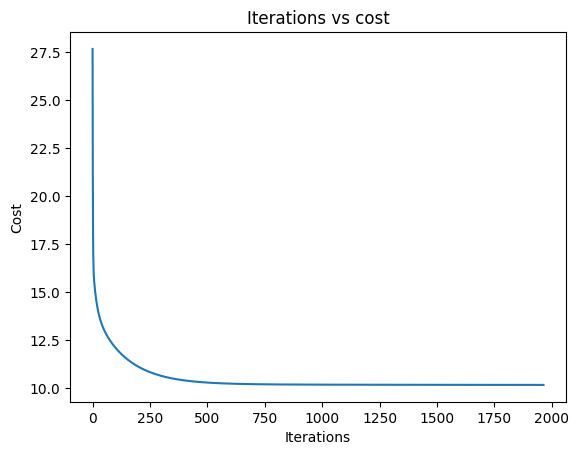

Root Mean Square Error:  11.217612379662134
Sum of Square Error:  32465.385495090082


In [55]:
model = linearregression(X, y,gd=True,reg=False,sgd = False,tolerance = 0.00001,learning_rate = 0.0005)
model.fit()

Data is full rank

Solving using Gradient Descent  Regularised


 13%|█▎        | 800/6000 [00:00<00:00, 19639.93it/s]

Model stopped Learning


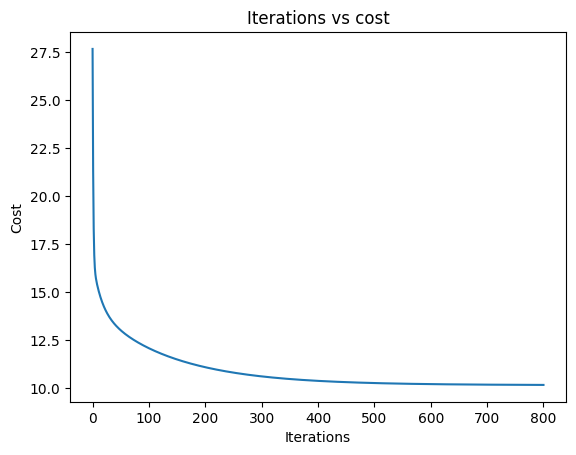

Root Mean Square Error:  11.234388854223933
Sum of Square Error:  32562.565175401025


In [51]:
model = linearregression(X, y,gd=True,reg=True,sgd = False,tolerance = 0.0001,learning_rate = 0.0005)
model.fit()

Data is full rank

Solving Using Stochastic Gradient Descent Not-Regularised


  1%|▏         | 80/6000 [00:00<00:48, 120.94it/s]


Model stopped Learning


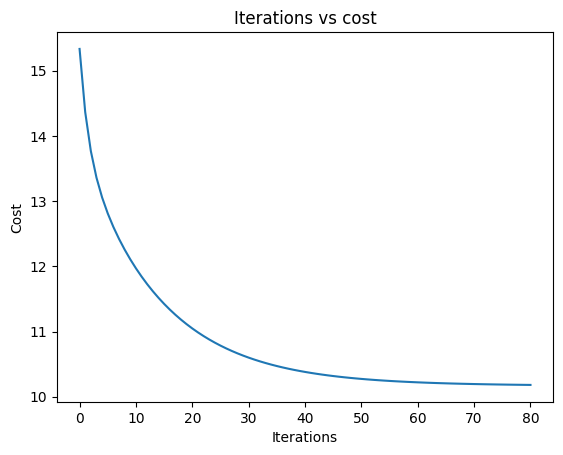

Root Mean Square Error:  11.2111124652705
Sum of Square Error:  32427.773018907443


In [47]:
model = linearregression(X, y,gd=False,reg=False,sgd = True,tolerance = 0.001,
                          learning_rate = 0.005,batch_size = 1)
model.fit()

Data is full rank

Solving Using Stochastic Gradient Descent Regularised


  6%|▌         | 362/6000 [00:02<00:36, 155.44it/s]


Model stopped Learning


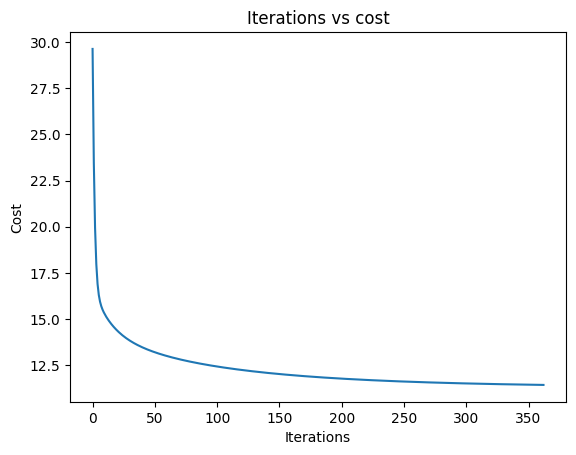

Root Mean Square Error:  11.858563087913618
Sum of Square Error:  36281.38377558706


In [46]:
model = linearregression(X, y,gd=False,reg=True,sgd = True,tolerance = 0.001,
                          learning_rate = 0.0005,batch_size = 1)
model.fit()

# Conclusion

Regularization keeps the model from fitting the training set too closely and becoming unduly complex. We found that by varying the regularization strength, denoted by the parameter "lambda," errors like SSE and RMSE were produced when lambda was increased, for example, to 1. In general, simpler models with smaller coefficients are produced by stronger regularization, which improves generalization but may sacrifice accuracy and result in more mistakes. On the other hand, models with larger coefficients and weaker regularization produce more complicated models that fit the training set better but run the risk of overfitting. Choosing the right lambda value is essential to prevent either overfitting or underfitting. Regularization can be chosen to be present (reg=True) or absent (reg=False) in the code.

The model's learning rate determines how quickly it learns new information. A very low learning rate could lead to delayed learning and drawn-out training, whereas a high rate could make the model learn too quickly and miss ideal answers. Setting a high learning rate of 0.1, for example, could cause the model to stop too soon, indicating insufficient learning and a failure to converge. On the other hand, a lower rate could make convergence and execution times longer. During gradient descent optimization, the learning speed can be specified thanks to the "learning_rate" argument in the code. Furthermore, the method offers the option to select between quicker but noisier stochastic gradient descent (sgd=True), which may converge more quickly but increase variation in the results, and regular gradient descent (gd=True).

Ultimately, careful tuning of regularization strength and learning rate significantly impacts model performance. Precise adjustment of these hyperparameters is essential to achieve optimal model outcomes.